## I Data preparation

### Packages loading

In [1]:
library("mclust")
library("Rtsne")
library("ggplot2")
library("reshape2")
library("dplyr")
library("dendextend")
library("cluster")
library("fpc")
library("FactoMineR")
library("factoextra")

Package 'mclust' version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.


Attachement du package : ‘dplyr’


Les objets suivants sont masqués depuis ‘package:stats’:

    filter, lag


Les objets suivants sont masqués depuis ‘package:base’:

    intersect, setdiff, setequal, union



---------------------
Welcome to dendextend version 1.16.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attachement du package : ‘dendextend’


L'objet suivant est masqué depuis ‘package:stats’:

    cutree


### Data loading

In [5]:
df1<-read.csv("trait.tsv", sep ="\t") # omit sep ="\t" for .csv files

### Clustering continous data

In [7]:
df1<-na.omit(df1)

In [8]:
df1<-df1 %>% arrange(bino)

In [9]:
mb1 = Mclust(as.numeric(df1$Consensus))
summary(mb1, parameters = TRUE)

---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust V (univariate, unequal variance) model with 3 components: 

 log-likelihood   n df      BIC       ICL
      -2970.748 528  8 -5991.65 -6199.418

Clustering table:
  1   2   3 
230 241  57 

Mixing probabilities:
        1         2         3 
0.3757443 0.4886236 0.1356321 

Means:
        1         2         3 
 53.96024 110.22617 371.97834 

Variances:
         1          2          3 
  306.8583  1623.2205 67828.3930 

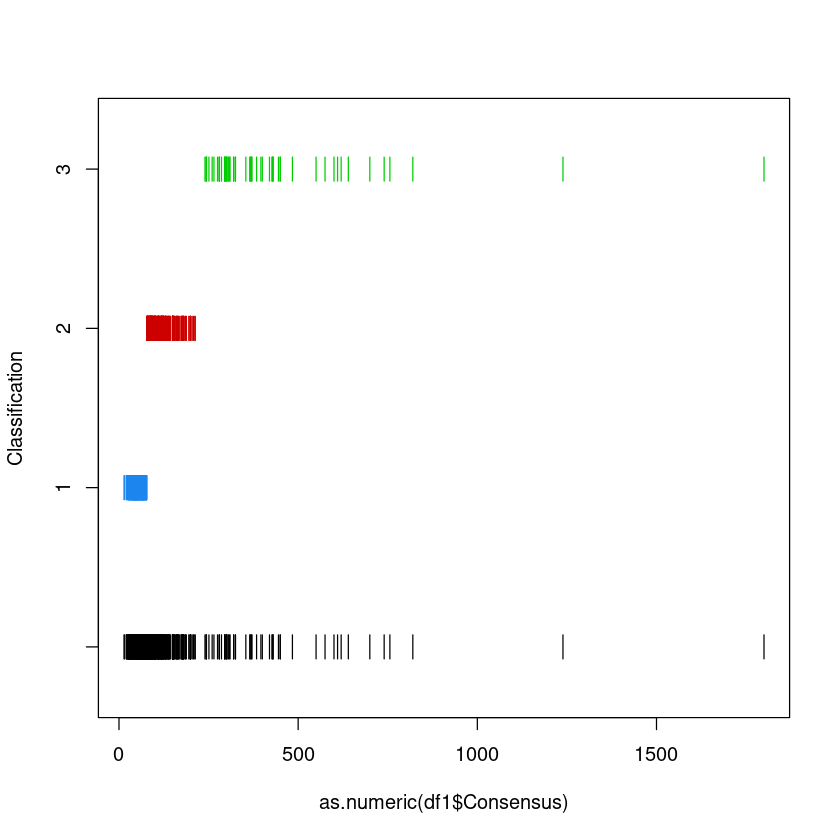

In [10]:
plot(mb1, what=c("classification")) # plot the discretization

In [11]:
df1<-(as.data.frame(unclass(df1),stringsAsFactors=TRUE))

In [12]:
df1$"body_size"<-log(df1$Consensus)

In [13]:
rownames(df1)<-df1[,1]
df1<-df1[-c(1,2)]

In [14]:
df1.1.1<-df1

In [15]:
df1.1.1$"body_size"<-as.factor(mb1$classification)

In [17]:
res.mca<-MCA(df1.1.1, ncp = 5, graph = TRUE)

In [18]:
eig.val <- get_eigenvalue(res.mca)

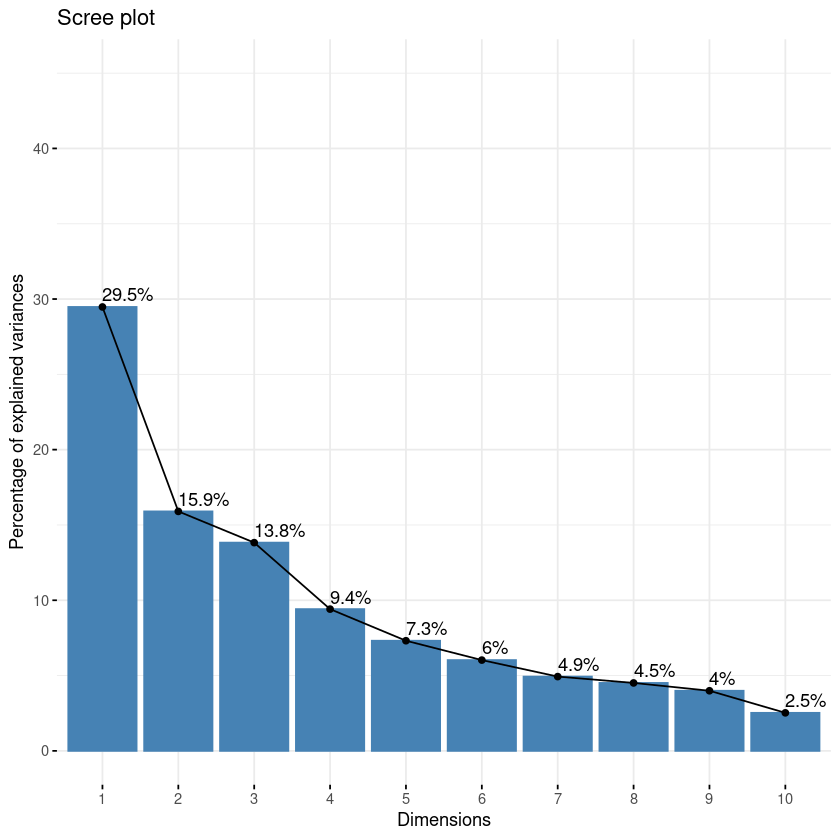

In [19]:
fviz_screeplot(res.mca, addlabels = TRUE, ylim = c(0, 45))

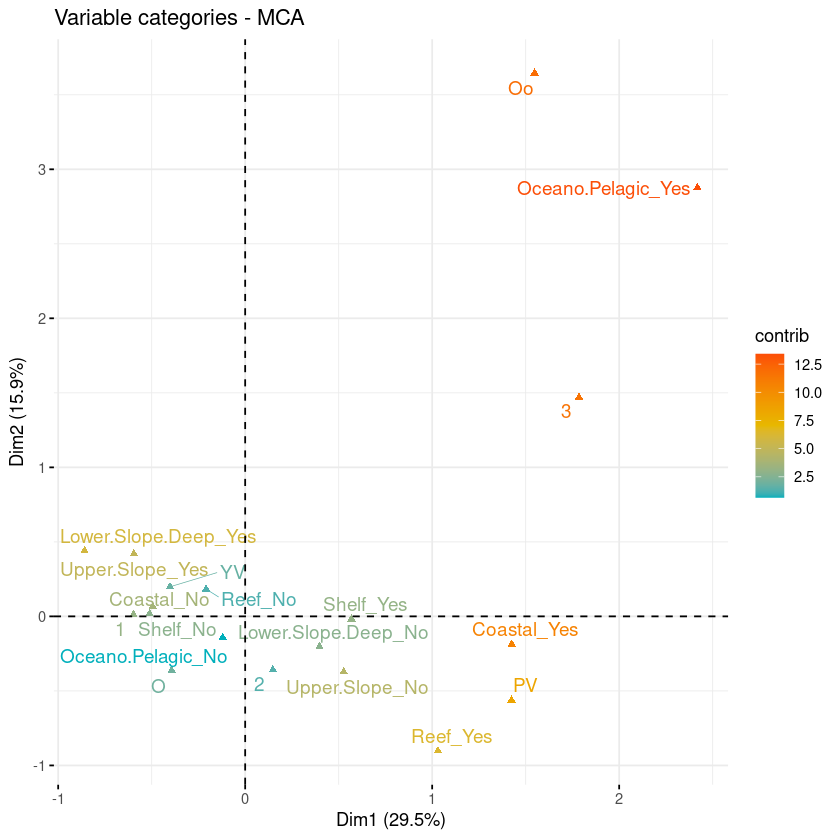

In [20]:
fviz_mca_var(res.mca, col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), 
             repel = TRUE, # avoid text overlapping (slow)
             ggtheme = theme_minimal()
             )

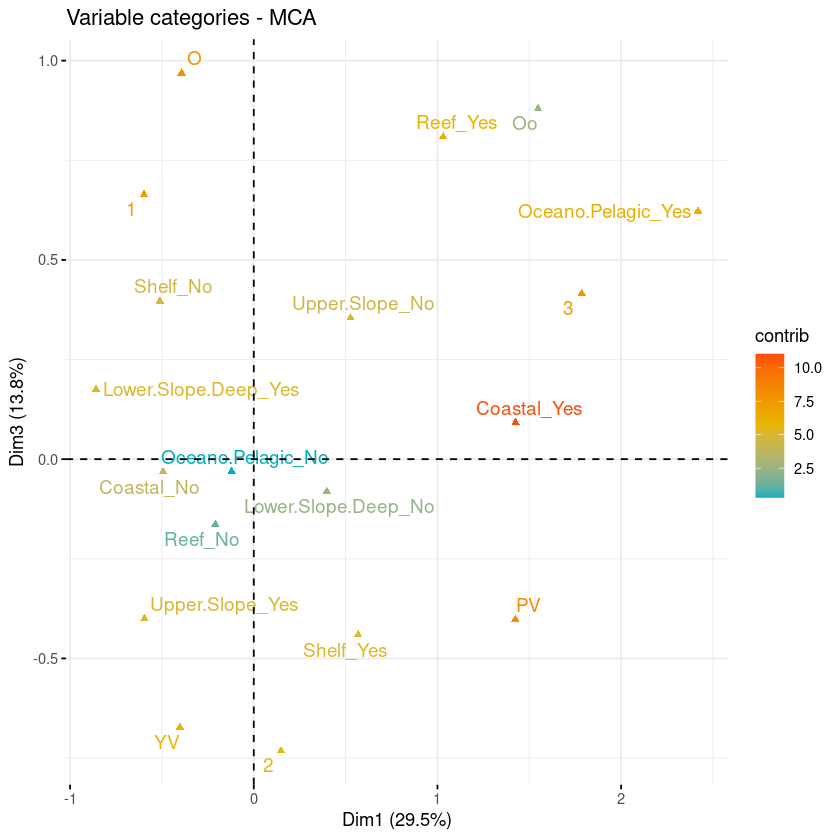

In [21]:
fviz_mca_var(res.mca, axes = c(1,3), col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), 
             repel = TRUE, # avoid text overlapping (slow)
             ggtheme = theme_minimal()
             )

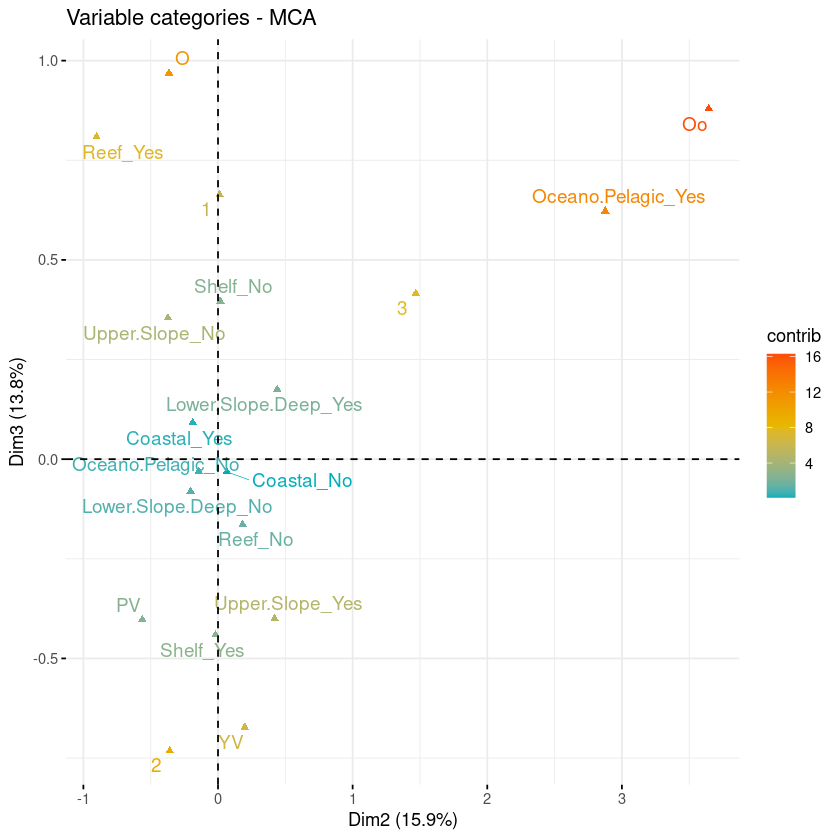

In [22]:
fviz_mca_var(res.mca, axes = c(2,3), col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), 
             repel = TRUE, # avoid text overlapping (slow)
             ggtheme = theme_minimal()
             )

## II Hierarchical clustering

### Dissimilarity matrix creation

In [25]:
gower.dist <- daisy(as.data.frame(df1), metric = c("gower"))

In [26]:
divisive.clust <- diana(as.matrix(gower.dist),diss = TRUE, keep.diss = TRUE)
aggl.clust.c <- hclust(gower.dist, method = "complete")
aggl.clust.m <- hclust(gower.dist, method = "average")
aggl.clust.w <- hclust(gower.dist, method = "ward.D2")

### 2-norm and  least square criterion

#### Complete

In [29]:
sigma <- var(gower.dist)+var(cophenetic(aggl.clust.c))
thres <- 2*sqrt(nrow(as.matrix(gower.dist))*sigma)
sign<-(thres > max(abs(svd(gower.dist-cophenetic(aggl.clust.c))$d)))
col.c<-c("Complete", thres, sign, sum((gower.dist-cophenetic(aggl.clust.c))**2))

#### UPGMA

In [31]:
sigma <- var(gower.dist)+var(cophenetic(aggl.clust.m))
thres <- 2*sqrt(nrow(as.matrix(gower.dist))*sigma)
sign<-(thres > max(abs(svd(gower.dist-cophenetic(aggl.clust.m))$d)))
col.m<-c("UPGMA", thres, sign, sum((gower.dist-cophenetic(aggl.clust.m))**2))

#### Ward

In [33]:
sigma <- var(gower.dist)+var(cophenetic(aggl.clust.w))
thres <- 2*sqrt(nrow(as.matrix(gower.dist))*sigma)
sign<-(thres > max(abs(svd(gower.dist-cophenetic(aggl.clust.w))$d)))
col.w<-c("Ward", thres, sign, sum((gower.dist-cophenetic(aggl.clust.w))**2))

#### Divisive

In [35]:
sigma <- var(gower.dist)+var(cophenetic(divisive.clust))
thres <- 2*sqrt(nrow(as.matrix(gower.dist))*sigma)
sign<-(thres > max(abs(svd(gower.dist-cophenetic(divisive.clust))$d)))
col.div<-c("Divisive", thres, sign, sum((gower.dist-cophenetic(divisive.clust))**2))

### Comparaison of algorithm dataframe

In [37]:
algo_sel <- rbind(col.c, col.m, col.w, col.div)
colnames(algo_sel)<-c("Name", "Threshold value", "Significance", "Least square")

In [38]:
algo_sel

,Name,Threshold value,Significance,Least square
col.c,Complete,15.8899480966262,FALSE,17868.6790835317
col.m,UPGMA,10.9893698329314,FALSE,2112.97328173017
col.w,Ward,94.8679286025524,FALSE,2444751.01318133
col.div,Divisive,15.7310253950952,FALSE,18787.7913794627


In [39]:
# Select the best algorithm, here : UPGMA

### Data repartition visualization

In [40]:
# Following the method presented by Anastasia Reusova in her blogpost in Towardsdatascience

In [41]:
cstats.table <- function(dist, tree, k) {
clust.assess <- c("cluster.number","n","within.cluster.ss","average.within","average.between",
                  "wb.ratio","dunn2","avg.silwidth")
clust.size <- c("cluster.size")
stats.names <- c()
row.clust <- c()
output.stats <- matrix(ncol = k, nrow = length(clust.assess))
cluster.sizes <- matrix(ncol = k, nrow = k)
    for(i in c(1:k)){
  row.clust[i] <- paste("Cluster-", i, " size")
}
    for(i in c(2:k)){
  stats.names[i] <- paste("Test", i-1)
  
  for(j in seq_along(clust.assess)){
    output.stats[j, i] <- unlist(cluster.stats(d = dist, clustering = cutree(tree, k = i))[clust.assess])[j]
    
  }
  
  for(d in 1:k) {
    cluster.sizes[d, i] <- unlist(cluster.stats(d = dist, clustering = cutree(tree, k = i))[clust.size])[d]
    dim(cluster.sizes[d, i]) <- c(length(cluster.sizes[i]), 1)
    cluster.sizes[d, i]
    
  }
}
    output.stats.df <- data.frame(output.stats)
    cluster.sizes <- data.frame(cluster.sizes)
cluster.sizes[is.na(cluster.sizes)] <- 0
    rows.all <- c(clust.assess, row.clust)
output <- rbind(output.stats.df, cluster.sizes)[ ,-1]
colnames(output) <- stats.names[2:k]
rownames(output) <- rows.all
is.num <- sapply(output, is.numeric)
output[is.num] <- lapply(output[is.num], round, 2)
output
}

In [42]:
stats.df.agglm <-cstats.table(gower.dist, aggl.clust.m, 8) 
stats.df.agglm

,Test 1,Test 2,Test 3,Test 4,Test 5,Test 6,Test 7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cluster.number,2.00,3.00,4.00,5.00,6.00,7.00,8.00
n,528.00,528.00,528.00,528.00,528.00,528.00,528.00
within.cluster.ss,26.88,21.69,13.37,11.75,11.56,9.31,6.87
average.within,0.28,0.25,0.19,0.18,0.18,0.16,0.13
average.between,0.51,0.50,0.45,0.45,0.45,0.44,0.43
wb.ratio,0.55,0.49,0.42,0.40,0.39,0.35,0.31
dunn2,1.68,1.56,1.65,1.67,1.53,1.45,1.45
avg.silwidth,0.43,0.41,0.44,0.45,0.45,0.43,0.48
Cluster- 1 size,369.00,369.00,157.00,157.00,157.00,72.00,72.00


### Elbow visualization

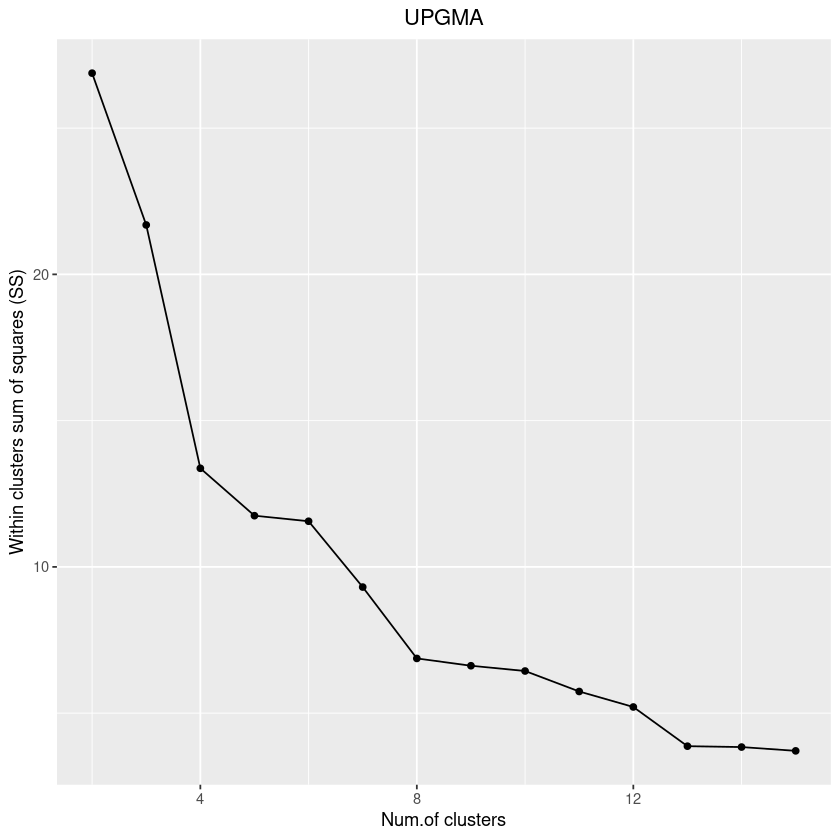

In [44]:
ggplot(data = data.frame(t(cstats.table(gower.dist, aggl.clust.m, 15))), 
  aes(x=cluster.number, y=within.cluster.ss)) + 
  geom_point()+
  geom_line()+
  ggtitle("UPGMA") +
  labs(x = "Num.of clusters", y = "Within clusters sum of squares (SS)") +
  theme(plot.title = element_text(hjust = 0.5))

### Silhouette visualization

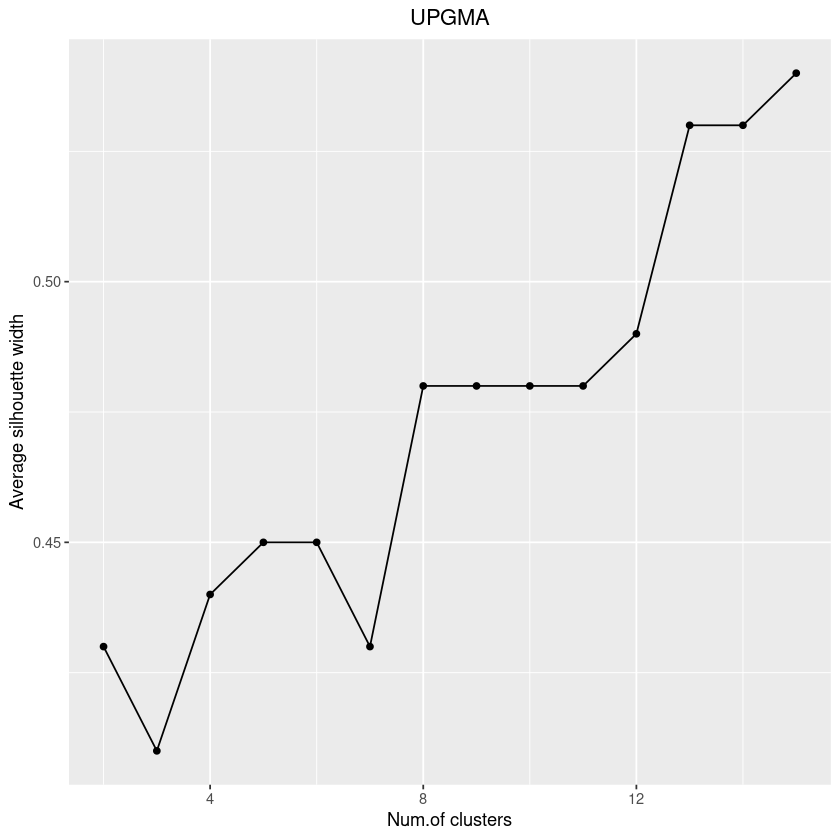

In [46]:
ggplot(data = data.frame(t(cstats.table(gower.dist, aggl.clust.m, 15))), 
  aes(x=cluster.number, y=avg.silwidth)) + 
  geom_point()+
  geom_line()+
  ggtitle("UPGMA") +
  labs(x = "Num.of clusters", y = "Average silhouette width") +
  theme(plot.title = element_text(hjust = 0.5))

#### Dendrogramme visualization

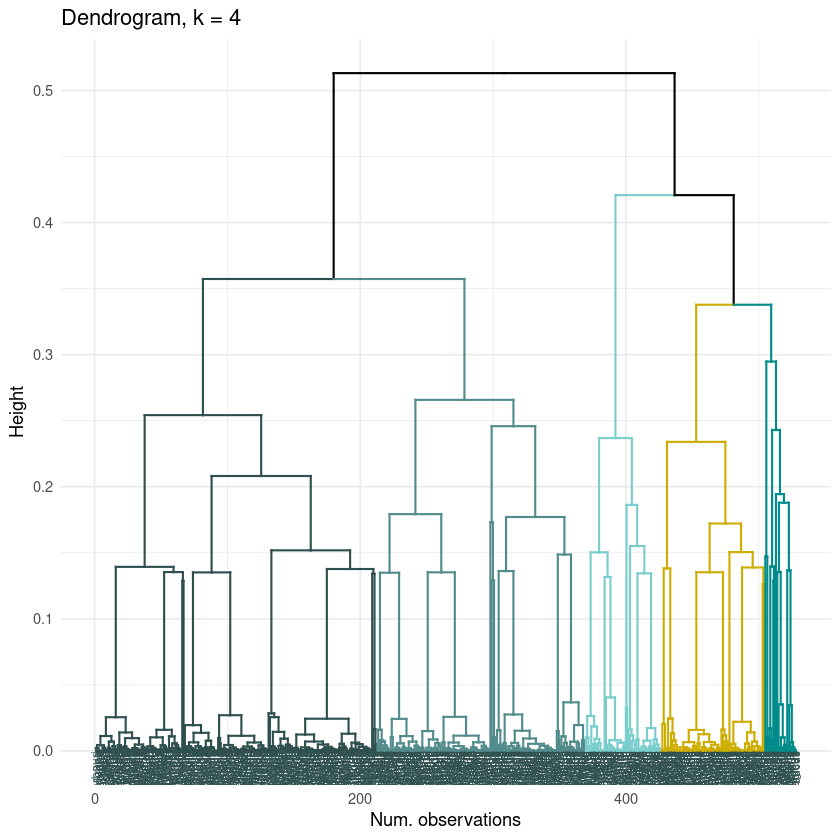

In [47]:
dendro <- as.dendrogram(aggl.clust.m)
dendro.col <- dendro %>%
  set("branches_k_color", k = 5, value =   c("darkslategray", "darkslategray4", "darkslategray3", "gold3", "darkcyan")) %>%
  set("branches_lwd", 0.6) %>%
  set("labels_colors", 
      value = c("darkslategray")) %>% 
  set("labels_cex", 0.5)
ggd1 <- as.ggdend(dendro.col)
ggplot(ggd1, theme = theme_minimal()) +
  labs(x = "Num. observations", y = "Height", title = "Dendrogram, k = 4")

In [ ]:
### Clearly indicates 5 groups

### Traits & repartition for optimal group number

In [51]:
clust.num <- cutree(aggl.clust.m, k = 5)
df<-cbind(df1, clust.num)
df<-as.data.frame(unclass(df),stringsAsFactors=TRUE)
summary(df[df[,length(df[1,])]== 1,])
summary(df[df[,length(df[1,])]== 2,])
summary(df[df[,length(df[1,])]== 3,])
summary(df[df[,length(df[1,])]== 4,])
summary(df[df[,length(df[1,])]== 5,])

 Reproduction Lower.Slope.Deep Upper.Slope Shelf      Reef     Coastal  
 O :52        No :135          No :69      No :  0   No :157   No :152  
 Oo: 3        Yes: 22          Yes:88      Yes:157   Yes:  0   Yes:  5  
 PV:16                                                                  
 YV:86                                                                  
                                                                        
                                                                        
 Oceano.Pelagic Your_variable     clust.num
 No :156        Min.   :3.497   Min.   :1  
 Yes:  1        1st Qu.:4.143   1st Qu.:1  
                Median :4.615   Median :1  
                Mean   :4.609   Mean   :1  
                3rd Qu.:5.011   3rd Qu.:1  
                Max.   :6.628   Max.   :1  

 Reproduction Lower.Slope.Deep Upper.Slope Shelf     Reef    Coastal 
 O : 0        No :24           No :20      No : 2   No :19   No : 1  
 Oo:12        Yes: 0           Yes: 4      Yes:22   Yes: 5   Yes:23  
 PV:10                                                               
 YV: 2                                                               
                                                                     
                                                                     
 Oceano.Pelagic Your_variable     clust.num
 No : 0         Min.   :4.477   Min.   :2  
 Yes:24         1st Qu.:5.712   1st Qu.:2  
                Median :6.058   Median :2  
                Mean   :6.036   Mean   :2  
                3rd Qu.:6.369   3rd Qu.:2  
                Max.   :7.496   Max.   :2  

 Reproduction Lower.Slope.Deep Upper.Slope Shelf      Reef     Coastal  
 O : 90       No : 67          No : 58     No :212   No :212   No :212  
 Oo:  4       Yes:145          Yes:154     Yes:  0   Yes:  0   Yes:  0  
 PV:  2                                                                 
 YV:116                                                                 
                                                                        
                                                                        
 Oceano.Pelagic Your_variable     clust.num
 No :212        Min.   :2.639   Min.   :3  
 Yes:  0        1st Qu.:3.738   1st Qu.:3  
                Median :4.060   Median :3  
                Mean   :4.058   Mean   :3  
                3rd Qu.:4.431   3rd Qu.:3  
                Max.   :5.136   Max.   :3  

 Reproduction Lower.Slope.Deep Upper.Slope Shelf     Reef    Coastal 
 O :40        No :57           No :55      No :50   No : 0   No :27  
 Oo: 0        Yes: 0           Yes: 2      Yes: 7   Yes:57   Yes:30  
 PV: 0                                                               
 YV:17                                                               
                                                                     
                                                                     
 Oceano.Pelagic Your_variable     clust.num
 No :57         Min.   :3.761   Min.   :4  
 Yes: 0         1st Qu.:4.248   1st Qu.:4  
                Median :4.466   Median :4  
                Mean   :4.564   Mean   :4  
                3rd Qu.:4.787   3rd Qu.:4  
                Max.   :5.869   Max.   :4  

 Reproduction Lower.Slope.Deep Upper.Slope Shelf     Reef    Coastal 
 O : 0        No :78           No :78      No :14   No :51   No : 0  
 Oo: 1        Yes: 0           Yes: 0      Yes:64   Yes:27   Yes:78  
 PV:66                                                               
 YV:11                                                               
                                                                     
                                                                     
 Oceano.Pelagic Your_variable     clust.num
 No :78         Min.   :4.174   Min.   :5  
 Yes: 0         1st Qu.:4.625   1st Qu.:5  
                Median :5.011   Median :5  
                Mean   :5.045   Mean   :5  
                3rd Qu.:5.451   3rd Qu.:5  
                Max.   :5.914   Max.   :5  

### Saving data

In [ ]:
write.table(df, "Trait_syndrom_tab.tsv", sep ="\t")